In [1]:
import os
import re
import sys
import itertools
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import StanfordNERTagger
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import enchant

from utils import pos_translator, remove_numbers, is_article_quote, \
                  is_copy_paste, ordinal_text2int, text2int

In [2]:
path_to_stanford_ner = "/Users/gogrean/code/stanford-ner-2014-06-16"

os.environ['STANFORD_MODELS'] = path_to_stanford_ner + "/classifiers"
os.environ['CLASSPATH'] = path_to_stanford_ner
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
d = enchant.Dict('en_US')

In [3]:
root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/elect2016/"

df_trump = pd.read_csv(root_dir + "data/trumps_tweets.csv")
df_clinton = pd.read_csv(root_dir + "data/clintons_tweets.csv")

I flag article quotes and copy-pasted tweets, and exclude them from the analysis. Trump, when tweeting from Android, often retweets by copy-pasting another user's tweet. These tweets are excluded from the analysis in their entirety, even if the retweet is followed by some of Trump's own words. The same thinking is applied to tweets that contain article quotes&mdash;even if part of the tweet contains one of the candidates' own words, the full tweet is excluded. Typical Twitter retweets are excluded as well.

In [4]:
for i, text in enumerate(df_trump.text):
    df_trump.at[i, 'copy_paste'] = is_copy_paste(text)
    df_trump.at[i, 'article_quote'] = is_article_quote(text)

for i, text in enumerate(df_clinton.text):
    df_clinton.at[i, 'copy_paste'] = is_copy_paste(text)
    df_clinton.at[i, 'article_quote'] = is_article_quote(text)

filtered_tweets_trump = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                 (df_trump.is_retweet == False)]
filtered_tweets_clinton = df_clinton[(df_clinton.copy_paste == False) & (df_clinton.article_quote == False) & 
                                     (df_clinton.is_retweet == False)]

Next I tokenize the tweets. Some of the tweets are not fully tokenized because words are separated by a dash or forward slash. `nltk` can't seem to deal with these, so I'm fixing the tweets by hand. Looping over the tweets, I tokenize the text, tag the words using the Stanford NER Tagger, and remove hashtags, user mentions, links, stopwords, 1-2 character words, punctuation marks, person names, and locations. I also exclude words that have forward slashes and formatted quotation marks in them. 

Because names that are written in all caps are not always recognized as names, I format every all-caps string using the `title()` method and re-tag the word. If the re-formatted word is still not recongized as a person name or location, I keep the word in the tweet.

Clinton's tweets are sometimes signed with "-H" or "[-]Hillary". I remove the signature from these tweets. Also, some of Clinton's tweets are written in Spanish. Only tweets written in English are included in the analysis.

The function `tag_corpus` takes a `method` argument that can be either `lemmatization` or `stemming` (default). This determines how the morphological analysis is done.

In [5]:
punctuation_marks = ["!", ".", "?", ";", ":", "?!", ")", "(", "'", 
                     '"', ",", "-", "...", "…", "``", "`", "’", "“", 
                     '#', "&", "@", "—", "–", "”", "‘"]
eos_punctuation_marks = [".", "!", "?"]

def make_corpus(df):
    n_chars, n_tokens = 0, 0
    tokenized_corpus = []
    flagged_indices = []
    url_regex = re.compile(r'https?:\/\/[a-zA-z0-9\/#%\.]+')
    for tweet, hashtags, mentions in zip(df.text, df.hashtags, df.user_mentions):
        n_chars += len(tweet)
        hashtag_list, mention_list = [], []
        if hashtags is not np.nan:
            hashtag_list = [h for h in hashtags.lower().split(", ")]
        if mentions is not np.nan:
            mention_list = [m for m in mentions.lower().split(", ")]
        tweet = re.sub(url_regex, '', tweet)
        tokens = word_tokenize(tweet)
        for dash in ["—", "–", "/"]:
            offset = 0
            split_words = [(i, word) for i, word in enumerate(tokens) if dash in word]
            for i, word in split_words:
                i += offset
                subwords = [subword for subword in word.split(dash) if subword != '']
                tokens[i:i+1] = subwords
                offset += (len(subwords) - 1)

        this_tweet_flagged_indices = [n_tokens + i 
                                      for i, w in enumerate(tokens) 
                                      if w.lower() in hashtag_list or w.lower() in mention_list]
        n_tokens += len(tokens)
        tokenized_corpus.extend(tokens)
        flagged_indices += this_tweet_flagged_indices
    return n_chars, flagged_indices, tokenized_corpus

def tag_corpus(tokenized_corpus, flagged_indices=[], method='stemming'):
    hillary = ['hillary', '-hillary', '-h', "–hillary", "—hillary"]
    stopset = stopwords.words('english')
    forbidden = ["http", "//", "amp", "una", "gun", "los", "que", "las", "arizona", "hardworking"] + punctuation_marks
    tags = st.tag(tokenized_corpus)
    modified_corpus = False
    for i, w in enumerate(tags):
        if w[0].isupper() and w[1] == 'O':
            tokenized_corpus[i] = w[0].title()
            modified_corpus = True
    if modified_corpus:
        tags = st.tag(tokenized_corpus)
    pos_tags = nltk.pos_tag(tokenized_corpus)
                
    for index in reversed(flagged_indices):
        del tags[index]
        del pos_tags[index]
                
    tags = remove_numbers(tags)
    pos_tags = remove_numbers(pos_tags)
    if method is 'lemmatization':
        words_in_corpus = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                           for w, p in zip(tags, pos_tags) 
                           if w[1] == 'O' and w[0].lower() not in stopset and
                           len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                           not any(f in w[0].lower() for f in forbidden) and 
                           w[0].lower() not in hillary]
    else:
        words_in_corpus = [porter_stemmer.stem(w[0].lower()) 
                           for w in tags
                           if w[1] == 'O' and w[0].lower() not in stopset and
                           len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                           not any(f in w[0].lower() for f in forbidden) and
                           w[0].lower() not in hillary]
    adjectives = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                  for w, p in zip(tags, pos_tags)
                  if w[1] == 'O' and w[0].lower() not in stopset and
                  len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                  not any(f in w[0].lower() for f in forbidden) and
                  (pos_translator(p[1]) == 'a') and
                  w[0].lower() not in hillary]
    adverbs = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
               for w, p in zip(tags, pos_tags)
               if w[1] == 'O' and w[0].lower() not in stopset and
               len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
               not any(f in w[0].lower() for f in forbidden) and
               (pos_translator(p[1]) == 'r') and
               w[0].lower() not in hillary]
    verbs = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1]))
             for w, p in zip(tags, pos_tags)
             if w[1] == 'O' and w[0].lower() not in stopset and
             len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
             not any(f in w[0].lower() for f in forbidden) and
             (pos_translator(p[1]) == 'v') and 
             w[0].lower() not in hillary]
    words = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1]))
             for w, p in zip(tags, pos_tags)
             if w[1] == 'O' and w[0].lower() not in stopset and
             len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
             not any(f in w[0].lower() for f in forbidden) and
             w[0].lower() not in hillary]
    n_words = len(words)
    unique_words = set(words_in_corpus)
    return n_words, unique_words, adjectives, adverbs, verbs, words

Mostly because I was curious about creating wordclouds in Python, below I show wordclouds based on Trump's and Clinton's tweets. Because Trump's tweets from Android have a different distribution than those from iPhone, indicating that the tweets from the different devices might be posted by different people, I separate Trump's wordclouds into one based on Android tweets and one based on iPhone tweets. For both candidates, I further divide their wordclouds into two: one containing only adjectives and another containing only verbs.

In [6]:
import random
from PIL import Image
from wordcloud import WordCloud

def rep_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (0, random.randint(10, 100), random.randint(40, 60))

def dem_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (224, random.randint(40, 100), random.randint(40, 60))

android = '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'
iphone = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
filtered_tweets_trump_android = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                         (df_trump.is_retweet == False) & 
                                         (df_trump.source == android)]
filtered_tweets_trump_iphone = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                         (df_trump.is_retweet == False) & 
                                         (df_trump.source == iphone)]

_, flagged_indices_trump_android, \
    corpus_trump_android = make_corpus(filtered_tweets_trump_android)
_, voc_trump_android, adj_trump_android, \
   adv_trump_android, verb_trump_android, _ = tag_corpus(corpus_trump_android, 
                                                         flagged_indices_trump_android, 
                                                         method='lemmatization')
adj_wordcloud_trump_android = " ".join([adj for adj in adj_trump_android])
verb_wordcloud_trump_android = " ".join([verb for verb in verb_trump_android])

_, flagged_indices_trump_iphone, \
    corpus_trump_iphone = make_corpus(filtered_tweets_trump_iphone)
_, voc_trump_iphone, adj_trump_iphone, \
   adv_trump_iphone, verb_trump_iphone, _ = tag_corpus(corpus_trump_iphone, 
                                                       flagged_indices_trump_iphone, 
                                                       method='lemmatization')
adj_wordcloud_trump_iphone = " ".join([adj for adj in adj_trump_iphone])
verb_wordcloud_trump_iphone = " ".join([verb for verb in verb_trump_iphone])

_, flagged_indices_clinton, \
    corpus_clinton_lem = make_corpus(filtered_tweets_clinton)
_, voc_clinton, adj_clinton, adv_clinton, verb_clinton, _ = tag_corpus(corpus_clinton_lem,
                                                                       flagged_indices_clinton, 
                                                                       method='lemmatization')
adj_wordcloud_clinton = " ".join([adj for adj in adj_clinton])
verb_wordcloud_clinton = " ".join([verb for verb in verb_clinton])

# masks taken from here:
# https://image.freepik.com/free-icon/elephant-republican-symbol_318-64492.jpg
# https://www.carstickers.com/prodimages/12960-democrat-donkey-sticker.png
republican_mask = np.array(Image.open(root_dir+'figs/republican-symbol.jpg'))
democrat_mask = np.array(Image.open(root_dir+'figs/democrat-symbol.jpg'))

# adjectives + adverbs
adj_wc_trump_android = WordCloud(background_color="white", 
                             max_words=100, min_font_size=8,
                             mask=republican_mask, width=5000, height=5000)
adj_wc_trump_android.generate(adj_wordcloud_trump_android)
adj_wc_trump_android.recolor(random_state=5, color_func=rep_color_func)

adj_wc_trump_iphone = WordCloud(background_color="white", 
                            max_words=100, min_font_size=8,
                            mask=republican_mask, width=5000, height=5000)
adj_wc_trump_iphone.generate(adj_wordcloud_trump_iphone)
adj_wc_trump_iphone.recolor(random_state=5, color_func=rep_color_func)

adj_wc_clinton = WordCloud(background_color="white", 
                       max_words=100, min_font_size=8,
                       mask=democrat_mask, width=5000, height=5000)
adj_wc_clinton.generate(adj_wordcloud_clinton)
adj_wc_clinton.recolor(random_state=5, color_func=dem_color_func)

# verbs
verb_wc_trump_android = WordCloud(background_color="white", 
                             max_words=100, min_font_size=8,
                             mask=republican_mask, width=5000, height=5000)
verb_wc_trump_android.generate(verb_wordcloud_trump_android)
verb_wc_trump_android.recolor(random_state=5, color_func=rep_color_func)

verb_wc_trump_iphone = WordCloud(background_color="white", 
                            max_words=100, min_font_size=8,
                            mask=republican_mask, width=5000, height=5000)
verb_wc_trump_iphone.generate(verb_wordcloud_trump_iphone)
verb_wc_trump_iphone.recolor(random_state=5, color_func=rep_color_func)

verb_wc_clinton = WordCloud(background_color="white", 
                       max_words=100, min_font_size=8,
                       mask=democrat_mask, width=5000, height=5000)
verb_wc_clinton.generate(verb_wordcloud_clinton)
verb_wc_clinton.recolor(random_state=5, color_func=dem_color_func)

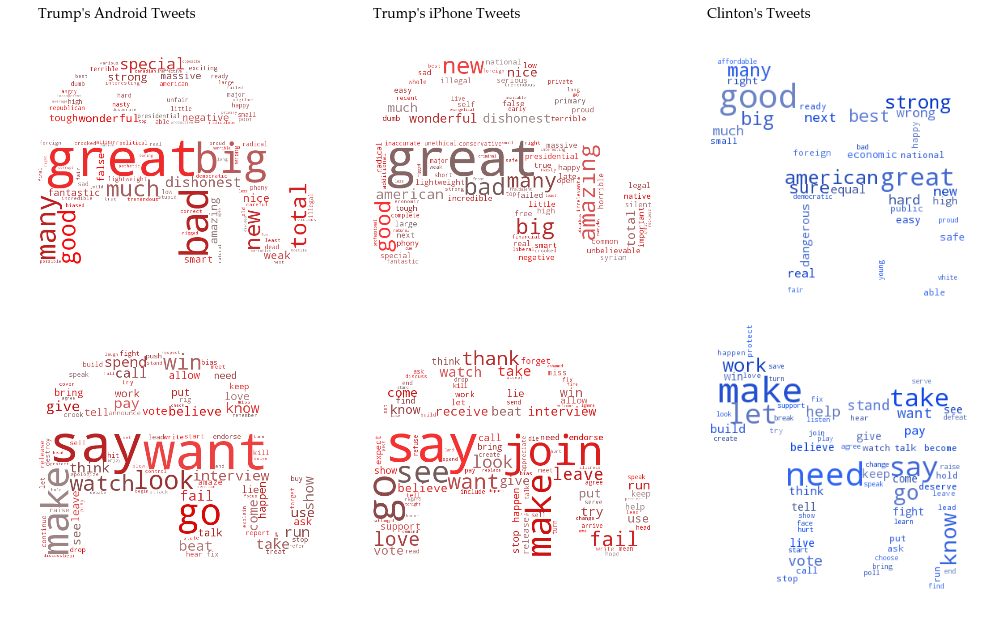

In [7]:
# do the wordcloud plotting
plt.rcParams.update({'font.size': 14})
plt.rcParams['xtick.labelsize'] = 14
pfont = {'fontname': 'Palatino Linotype'}

fig, ax = plt.subplots(2, 3, figsize=(17,14))

ax[0,0].set_title("Trump's Android Tweets", loc='left', fontsize=14, **pfont)
ax[0,0].imshow(adj_wc_trump_android)
ax[0,0].axis('off')

ax[0,1].set_title("Trump's iPhone Tweets", loc='left', fontsize=14, **pfont)
ax[0,1].imshow(adj_wc_trump_iphone)
ax[0,1].axis('off')

ax[0,2].set_title("Clinton's Tweets", loc='left', fontsize=14, **pfont)
ax[0,2].imshow(adj_wc_clinton)
ax[0,2].axis('off')

ax[1,0].imshow(verb_wc_trump_android)
ax[1,0].axis('off')

ax[1,1].imshow(verb_wc_trump_iphone)
ax[1,1].axis('off')

ax[1,2].imshow(verb_wc_clinton)
ax[1,2].axis('off')

plt.subplots_adjust(hspace=-0.4)

In [8]:
fig.savefig(root_dir + 'figs/POS_wordclouds_twitter.png', dpi=400)

Below I look in a more quantitative way at the top 20 adjectives and verbs used in each candidate's tweets. 

In [9]:
import operator 

n_chars_trump, flagged_indices_trump, corpus_trump = make_corpus(filtered_tweets_trump)
n_words_trump, voc_trump, adj_trump, adv_trump, verb_trump, \
words_trump = tag_corpus(corpus_trump, flagged_indices_trump)

n_chars_clinton, flagged_indices_clinton, corpus_clinton = make_corpus(filtered_tweets_clinton)
n_words_clinton, voc_clinton, adj_clinton, adv_clinton, verb_clinton, \
words_clinton = tag_corpus(corpus_clinton, flagged_indices_clinton)

adj_trump_bucket = {}
unique_adj_trump = np.unique(adj_trump)
for a in unique_adj_trump:
    adj_trump_bucket[a] = adj_trump.count(a)
sorted_adj_trump_bucket = sorted(adj_trump_bucket.items(), 
                                 key=operator.itemgetter(1))

vb_trump_bucket = {}
unique_vb_trump = np.unique(verb_trump)
for a in unique_vb_trump:
    vb_trump_bucket[a] = verb_trump.count(a)
sorted_vb_trump_bucket = sorted(vb_trump_bucket.items(), 
                                key=operator.itemgetter(1))

adj_clinton_bucket = {}
unique_adj_clinton = np.unique(adj_clinton)
for a in unique_adj_clinton:
    adj_clinton_bucket[a] = adj_clinton.count(a)
sorted_adj_clinton_bucket = sorted(adj_clinton_bucket.items(), 
                                   key=operator.itemgetter(1))

vb_clinton_bucket = {}
unique_vb_clinton = np.unique(verb_clinton)
for a in unique_vb_clinton:
    vb_clinton_bucket[a] = verb_clinton.count(a)
sorted_vb_clinton_bucket = sorted(vb_clinton_bucket.items(), 
                                  key=operator.itemgetter(1))

In [10]:
n_top_words = 20
top_adj_clinton = [x[0] for x in sorted_adj_clinton_bucket[-n_top_words:]]
top_adj_trump = [x[0] for x in sorted_adj_trump_bucket[-n_top_words:]]

n_adj_clinton = len(adj_clinton)
n_adj_trump = len(adj_trump)

plot_top_adj = {}
top_adj = set(top_adj_trump + top_adj_clinton)
for adj in top_adj:
    plot_top_adj[adj] = [[x[1]/n_adj_clinton*100 for x in sorted_adj_clinton_bucket if x[0] == adj],
                         [x[1]/n_adj_trump*100 for x in sorted_adj_trump_bucket if x[0] == adj]]
    if not plot_top_adj[adj][0]:
        plot_top_adj[adj][0] = 0
    else:
        plot_top_adj[adj][0] = plot_top_adj[adj][0][0]
    if not plot_top_adj[adj][1]:
        plot_top_adj[adj][1] = 0
    else:
        plot_top_adj[adj][1] = plot_top_adj[adj][1][0]

sorted_adj = sorted(plot_top_adj.items(), key=lambda x: sum(x[1]))


top_vb_clinton = [x[0] for x in sorted_vb_clinton_bucket[-n_top_words:]]
top_vb_trump = [x[0] for x in sorted_vb_trump_bucket[-n_top_words:]]

n_vb_clinton = len(verb_clinton)
n_vb_trump = len(verb_trump)

plot_top_vb = {}
top_vb = set(top_vb_trump + top_vb_clinton)
for vb in top_vb:
    plot_top_vb[vb] = [[x[1]/n_vb_clinton*100 for x in sorted_vb_clinton_bucket if x[0] == vb],
                         [x[1]/n_vb_trump*100 for x in sorted_vb_trump_bucket if x[0] == vb]]
    if not plot_top_vb[vb][0]:
        plot_top_vb[vb][0] = 0
    else:
        plot_top_vb[vb][0] = plot_top_vb[vb][0][0]
    if not plot_top_vb[vb][1]:
        plot_top_vb[vb][1] = 0
    else:
        plot_top_vb[vb][1] = plot_top_vb[vb][1][0]
        
sorted_vb = sorted(plot_top_vb.items(), key=lambda x: sum(x[1]))

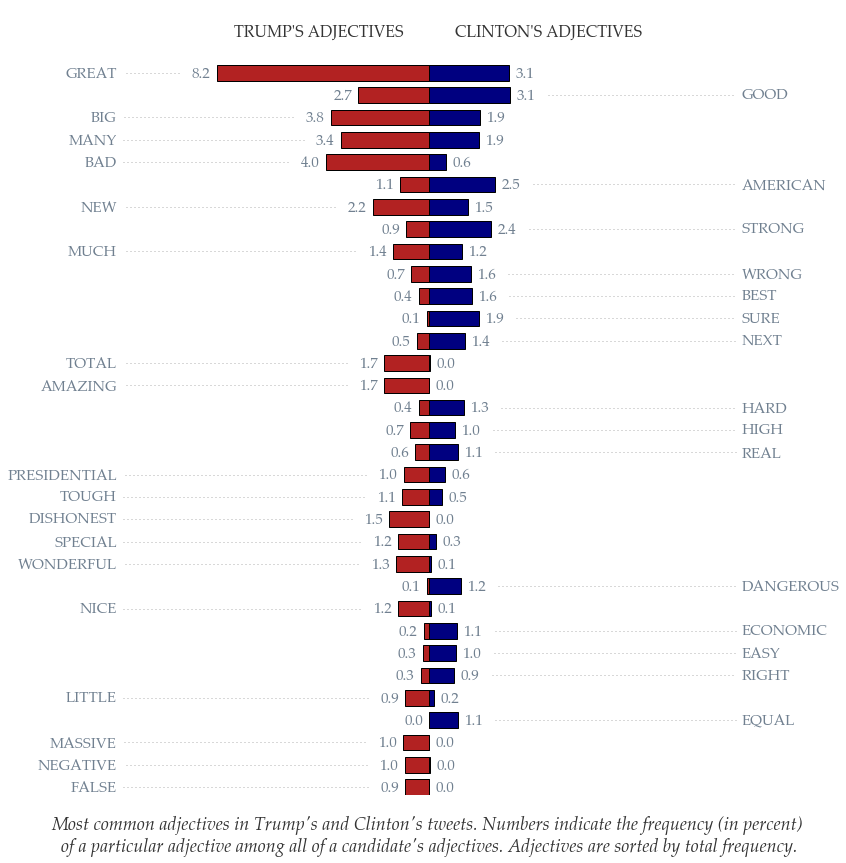

In [11]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(14,14), frameon=False)
plt.axis('off')

bar_pos = np.arange(len(plot_top_adj))
bar_width = 0.7

plt.barh(bar_pos, 
        [x[1][0] for x in sorted_adj], 
        color='navy', height=bar_width)
plt.barh(bar_pos,
        [-x[1][1] for x in sorted_adj],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, adj in enumerate(sorted_adj):
    if adj[1][0] > adj[1][1]:
        tloc = 12
        talign = 'left'
        talign_op = 'right'
    else:
        tloc = -12
        talign = 'right'
        talign_op = 'left'
    offset = abs(tloc)/50*np.sign(tloc)
    lstart = np.max(adj[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(adj[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, adj[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(adj[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(adj[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.text(np.min(adj[1]) * -1 * np.sign(tloc) - offset, i, "%.1f" % np.min(adj[1]), 
             ha=talign_op, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-1, len(sorted_adj)+1, "TRUMP'S ADJECTIVES", ha='right', fontsize=16, alpha=0.8, **pfont)
plt.text(1, len(sorted_adj)+1, "CLINTON'S ADJECTIVES", ha='left', fontsize=16, alpha=0.8, **pfont)
plt.text(0, -2.5, 
         """Most common adjectives in Trump's and Clinton's tweets. Numbers indicate the frequency (in percent) 
of a particular adjective among all of a candidate's adjectives. Adjectives are sorted by total frequency.""", 
fontsize=18, alpha=0.8, ha='center', style='italic', **pfont)
plt.savefig('../figs/common_adj.pdf')

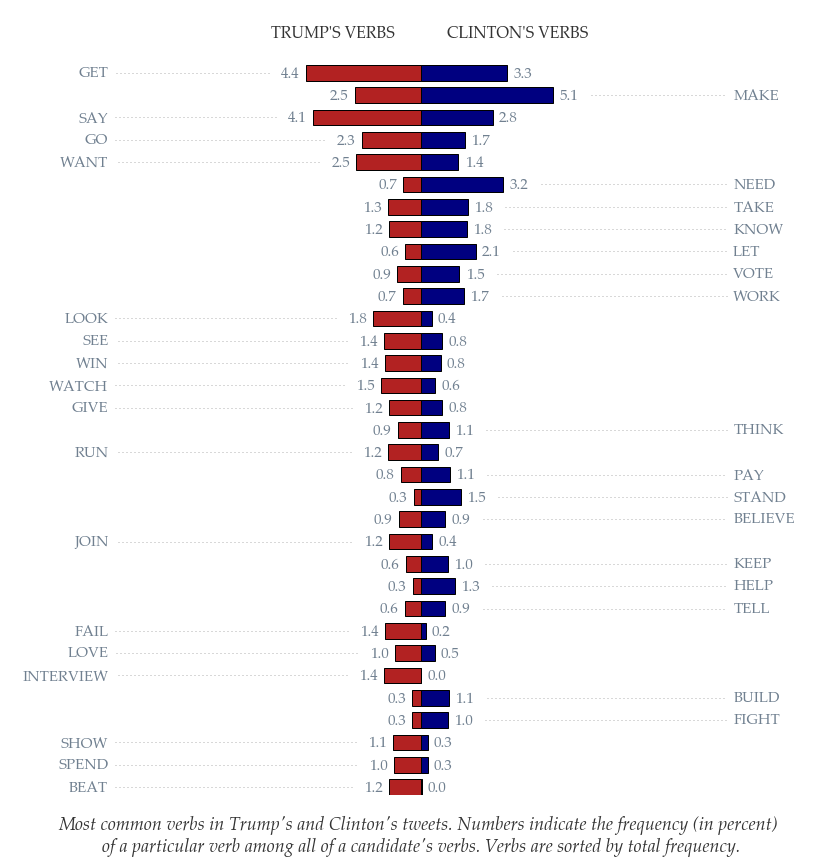

In [12]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(14,14), frameon=False)
plt.axis('off')

bar_pos = np.arange(len(plot_top_vb))
bar_width = 0.7

plt.barh(bar_pos, 
        [x[1][0] for x in sorted_vb], 
        color='navy', height=bar_width)
plt.barh(bar_pos,
        [-x[1][1] for x in sorted_vb],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, vb in enumerate(sorted_vb):
    if vb[1][0] > vb[1][1]:
        tloc = 12
        talign = 'left'
        talign_op = 'right'
    else:
        tloc = -12
        talign = 'right'
        talign_op = 'left'
    offset = abs(tloc)/50*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.text(np.min(vb[1]) * -1 * np.sign(tloc) - offset, i, "%.1f" % np.min(vb[1]), 
             ha=talign_op, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-1, len(sorted_vb)+1, "TRUMP'S VERBS", ha='right', fontsize=16, alpha=0.8, **pfont)
plt.text(1, len(sorted_vb)+1, "CLINTON'S VERBS", ha='left', fontsize=16, alpha=0.8, **pfont)
plt.text(0, -2.5, 
         """Most common verbs in Trump's and Clinton's tweets. Numbers indicate the frequency (in percent) 
of a particular verb among all of a candidate's verbs. Verbs are sorted by total frequency.""", 
fontsize=18, alpha=0.8, ha='center', style='italic', **pfont)
plt.savefig('../figs/common_vb.pdf')

In [13]:
n_adj_clinton = len(adj_clinton)
n_adj_trump = len(adj_trump)

plot_top_adj = {}
all_adj = set(adj_clinton + adj_trump)
for adj in all_adj:
    if adj not in adj_clinton or adj not in adj_trump:
        continue
    plot_top_adj[adj] = [[x[1]/n_adj_clinton*100 for x in sorted_adj_clinton_bucket if x[0] == adj],
                         [x[1]/n_adj_trump*100 for x in sorted_adj_trump_bucket if x[0] == adj]]
    if not plot_top_adj[adj][0]:
        plot_top_adj[adj][0] = 0
    else:
        plot_top_adj[adj][0] = plot_top_adj[adj][0][0]
    if not plot_top_adj[adj][1]:
        plot_top_adj[adj][1] = 0
    else:
        plot_top_adj[adj][1] = plot_top_adj[adj][1][0]

adj_ratio = [(adj, n[0]/n[1]) for adj, n in plot_top_adj.items() if n[0]/n[1] >= 5]
sorted_adj_ratio_clinton = sorted(adj_ratio, key=lambda x: x[1])

adj_ratio = [(adj, n[1]/n[0]) for adj, n in plot_top_adj.items() if n[1]/n[0] >= 5]
sorted_adj_ratio_trump = sorted(adj_ratio, key=lambda x: x[1])


n_vb_clinton = len(verb_clinton)
n_vb_trump = len(verb_trump)

plot_top_vb = {}
all_vb = set(verb_clinton + verb_trump)
for vb in all_vb:
    if vb not in verb_clinton or vb not in verb_trump:
        continue
    plot_top_vb[vb] = [[x[1]/n_vb_clinton*100 for x in sorted_vb_clinton_bucket if x[0] == vb],
                         [x[1]/n_vb_trump*100 for x in sorted_vb_trump_bucket if x[0] == vb]]
    if not plot_top_vb[vb][0]:
        plot_top_vb[vb][0] = 0
    else:
        plot_top_vb[vb][0] = plot_top_vb[vb][0][0]
    if not plot_top_vb[vb][1]:
        plot_top_vb[vb][1] = 0
    else:
        plot_top_vb[vb][1] = plot_top_vb[vb][1][0]

vb_ratio = [(vb, n[0]/n[1]) for vb, n in plot_top_vb.items() if n[0]/n[1] >= 5]
sorted_vb_ratio_clinton = sorted(vb_ratio, key=lambda x: x[1])

vb_ratio = [(vb, n[1]/n[0]) for vb, n in plot_top_vb.items() if n[1]/n[0] >= 5]
sorted_vb_ratio_trump = sorted(vb_ratio, key=lambda x: x[1])

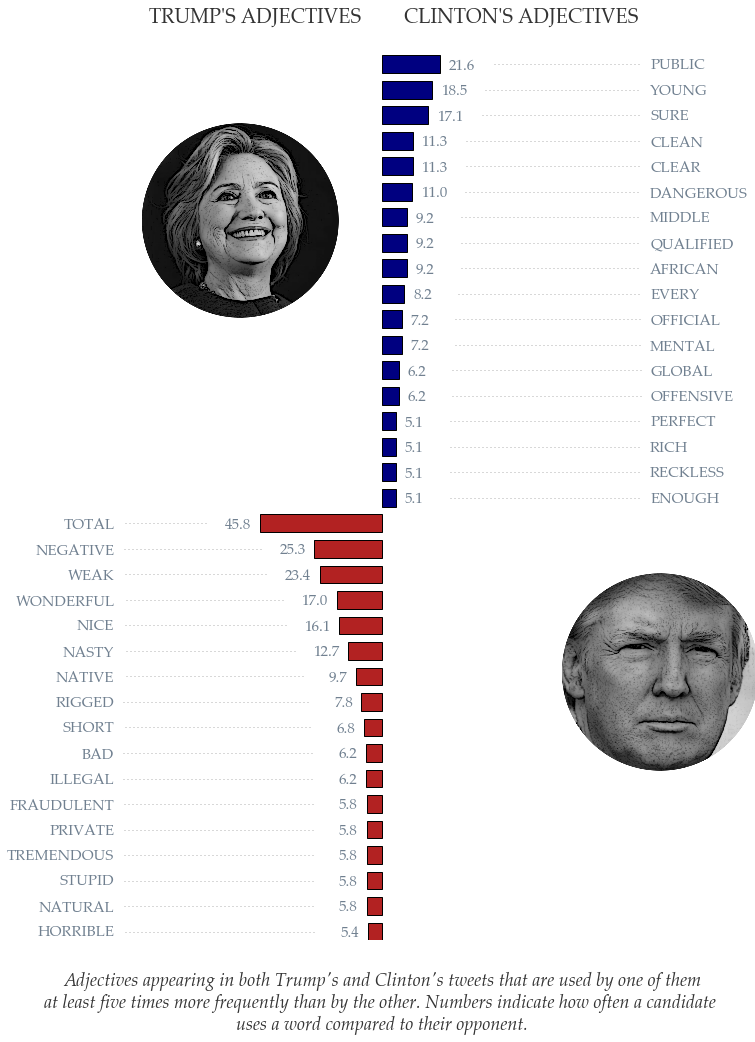

In [21]:
from PIL import Image

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(12,16), frameon=False)
plt.axis('off')

bar_pos_trump = np.arange(len(sorted_adj_ratio_trump))
bar_pos_clinton = len(sorted_adj_ratio_trump) + np.arange(len(sorted_adj_ratio_clinton))
bar_width = 0.7

plt.barh(bar_pos_clinton, 
        [x[1] for x in sorted_adj_ratio_clinton], 
        color='navy', height=bar_width)
plt.barh(bar_pos_trump,
        [-x[1] for x in sorted_adj_ratio_trump],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, adj in zip(bar_pos_trump, sorted_adj_ratio_trump):
    tloc = -100
    talign = 'right'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(adj[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(adj[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, adj[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(adj[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(adj[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)
for i, adj in zip(bar_pos_clinton, sorted_adj_ratio_clinton):
    tloc = 100
    talign = 'left'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(adj[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(adj[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, adj[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(adj[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(adj[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-8, np.max(bar_pos_clinton)+2.0, "TRUMP'S ADJECTIVES", ha='right', fontsize=20, alpha=0.8, **pfont)
plt.text(8, np.max(bar_pos_clinton)+2.0, "CLINTON'S ADJECTIVES", ha='left', fontsize=20, alpha=0.8, **pfont)
plt.text(0, -3.5, 
         """Adjectives appearing in both Trump's and Clinton's tweets that are used by one of them
at least five times more frequently than by the other. Numbers indicate how often a candidate 
uses a word compared to their opponent.""", fontsize=18, alpha=0.8, 
         ha='center', style='italic', **pfont)

hc_sketch = Image.open('../figs/clinton-sketch-gimp.png')
hc_sketch = hc_sketch.resize((int(hc_sketch.size[0]//2), int(hc_sketch.size[1]//2)))
hc_sketch = np.array(hc_sketch).astype(np.float) / 255
fig.figimage(hc_sketch, 140, 720, origin='upper', cmap='gray')

dt_sketch = Image.open('../figs/trump-sketch-gimp.png')
dt_sketch = dt_sketch.resize((int(dt_sketch.size[0]//2), int(dt_sketch.size[1]//2)))
dt_sketch = np.array(dt_sketch).astype(np.float) / 255
fig.figimage(dt_sketch, 560, 270, origin='upper', cmap='gray')

plt.savefig('../figs/adj_differences.pdf')

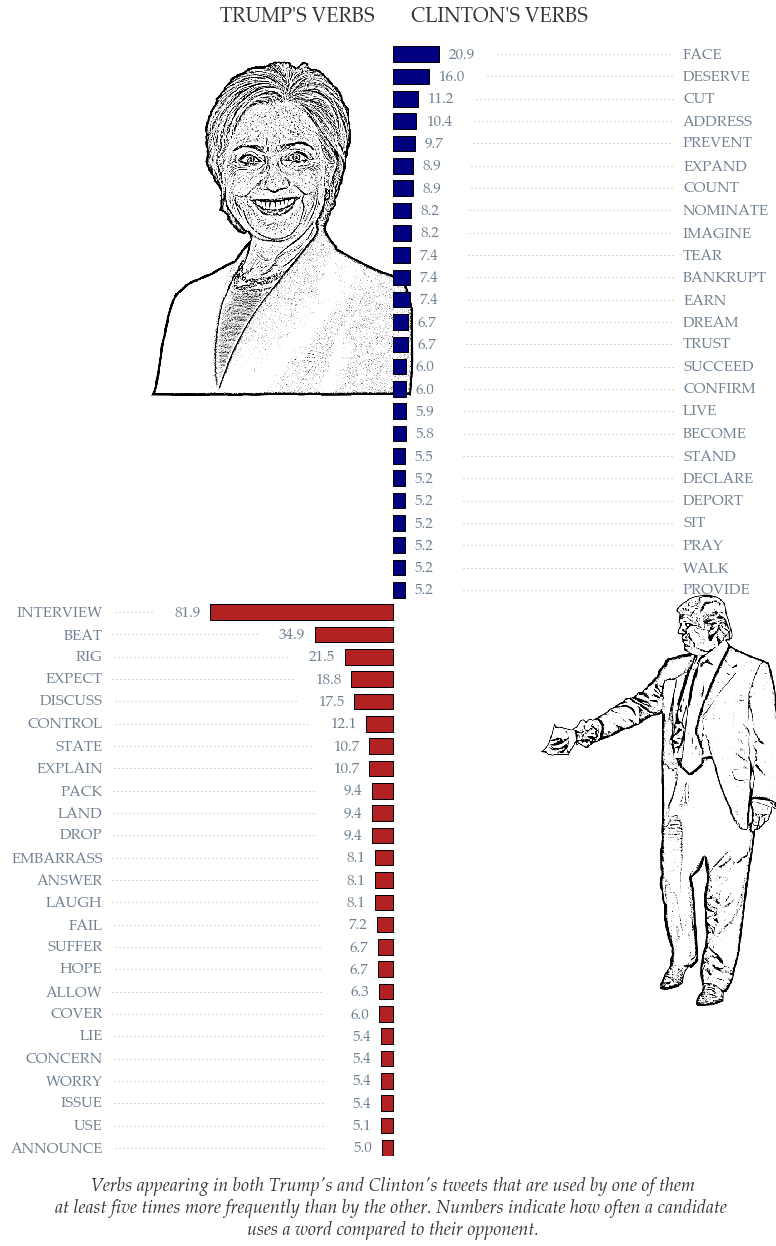

In [15]:
from PIL import Image

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(13,20), frameon=False)
plt.axis('off')

bar_pos_trump = np.arange(len(sorted_vb_ratio_trump))
bar_pos_clinton = len(sorted_vb_ratio_trump) + np.arange(len(sorted_vb_ratio_clinton))
bar_width = 0.7

plt.barh(bar_pos_clinton, 
        [x[1] for x in sorted_vb_ratio_clinton], 
        color='navy', height=bar_width)
plt.barh(bar_pos_trump,
        [-x[1] for x in sorted_vb_ratio_trump],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, vb in zip(bar_pos_trump, sorted_vb_ratio_trump):
    tloc = -130
    talign = 'right'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)
for i, vb in zip(bar_pos_clinton, sorted_vb_ratio_clinton):
    tloc = 130
    talign = 'left'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-8, np.max(bar_pos_clinton)+1.8, "TRUMP'S VERBS", ha='right', fontsize=20, alpha=0.8, **pfont)
plt.text(8, np.max(bar_pos_clinton)+1.8, "CLINTON'S VERBS", ha='left', fontsize=20, alpha=0.8, **pfont)
plt.text(0, -3.5, 
         """Verbs appearing in both Trump's and Clinton's tweets that are used by one of them
at least five times more frequently than by the other. Numbers indicate how often a candidate 
uses a word compared to their opponent.""", fontsize=18, alpha=0.8, 
         ha='center', style='italic', **pfont)

hc_sketch = Image.open('../figs/hillary-sketch.png')
hc_sketch = hc_sketch.resize((int(hc_sketch.size[0]//2.2), int(hc_sketch.size[1]//2.2)))
hc_sketch = np.array(hc_sketch).astype(np.float) / 255
fig.figimage(hc_sketch, 130, 850, origin='upper', cmap='gray')

dt_sketch = Image.open('../figs/trump-sketch.png')
dt_sketch = dt_sketch.resize((int(dt_sketch.size[0]//1.8), int(dt_sketch.size[1]//1.8)))
dt_sketch = np.array(dt_sketch).astype(np.float) / 255
fig.figimage(dt_sketch, 540, 240, origin='upper', cmap='gray')

plt.savefig('../figs/vb_differences.pdf')

In [16]:
n_adj_clinton = len(adj_clinton)
n_adj_trump = len(adj_trump)

unique_trump_adj = {}
for adj in set(adj_trump):
    if adj not in adj_clinton:
        unique_trump_adj[adj] = adj_trump.count(adj) / n_adj_trump * 100

unique_clinton_adj = {}
for adj in set(adj_clinton):
    if adj not in adj_trump:
        unique_clinton_adj[adj] = adj_clinton.count(adj) / n_adj_clinton * 100

sorted_unique_trump_adj = sorted(unique_trump_adj.items(), key=lambda x: x[1])[-n_top_words:]
sorted_unique_clinton_adj = sorted(unique_clinton_adj.items(), key=lambda x: x[1])[-n_top_words:]


n_vb_clinton = len(verb_clinton)
n_vb_trump = len(verb_trump)

unique_trump_vb = {}
for vb in set(verb_trump):
    if vb not in verb_clinton:
        unique_trump_vb[vb] = verb_trump.count(vb) / n_vb_trump * 100

unique_clinton_vb = {}
for vb in set(verb_clinton):
    if vb not in verb_trump:
        unique_clinton_vb[vb] = verb_clinton.count(vb) / n_vb_clinton * 100

sorted_unique_trump_vb = sorted(unique_trump_vb.items(), key=lambda x: x[1])[-n_top_words:]
sorted_unique_clinton_vb = sorted(unique_clinton_vb.items(), key=lambda x: x[1])[-n_top_words:]

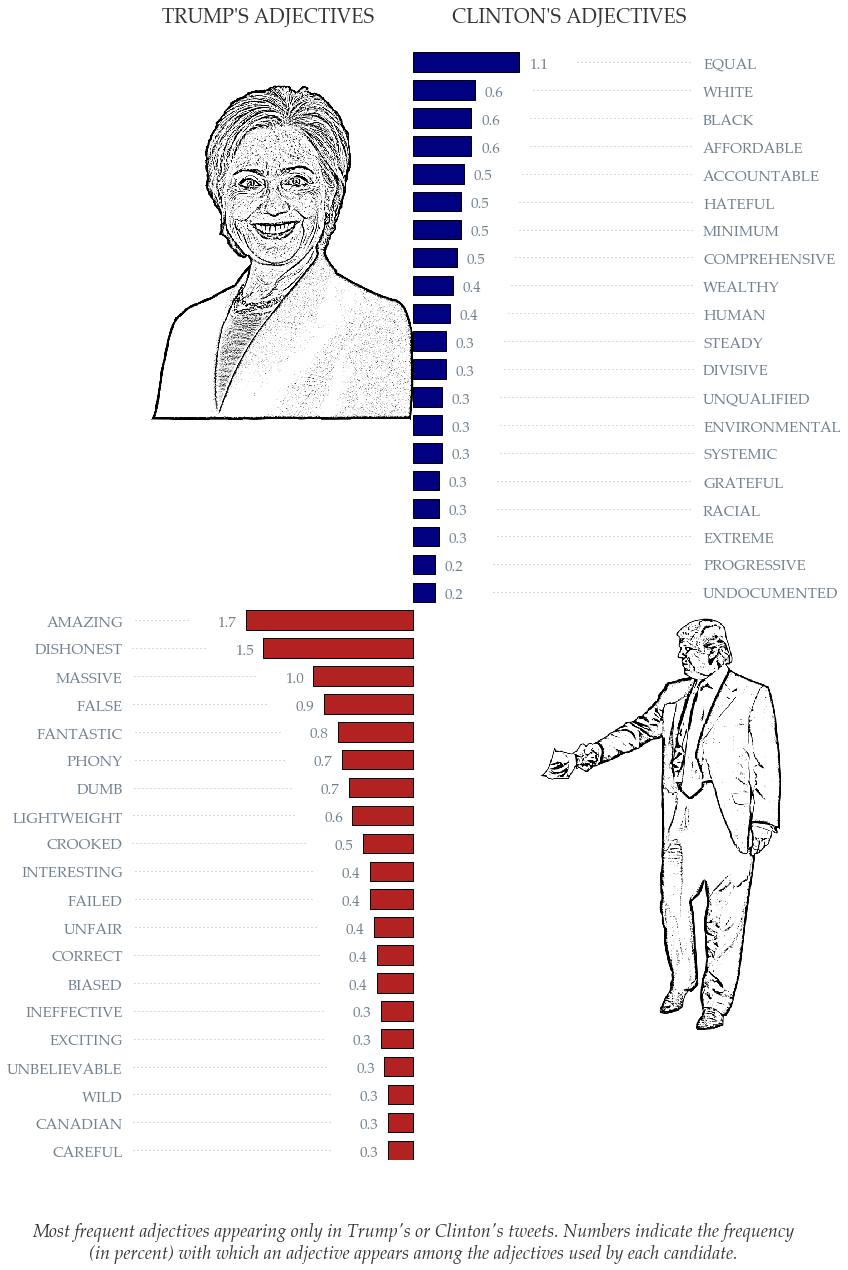

In [17]:
from PIL import Image

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(13,20), frameon=False)
plt.axis('off')

bar_pos_trump = np.arange(len(sorted_unique_trump_adj))
bar_pos_clinton = len(sorted_unique_trump_adj) + np.arange(len(sorted_unique_clinton_adj))
bar_width = 0.7

plt.barh(bar_pos_clinton, 
        [x[1] for x in sorted_unique_clinton_adj], 
        color='navy', height=bar_width)
plt.barh(bar_pos_trump,
        [-x[1] for x in sorted_unique_trump_adj],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, vb in zip(bar_pos_trump, sorted_unique_trump_adj):
    tloc = -3
    talign = 'right'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)
for i, vb in zip(bar_pos_clinton, sorted_unique_clinton_adj):
    tloc = 3
    talign = 'left'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-0.4, np.max(bar_pos_clinton)+1.8, "TRUMP'S ADJECTIVES", ha='right', fontsize=20, alpha=0.8, **pfont)
plt.text(0.4, np.max(bar_pos_clinton)+1.8, "CLINTON'S ADJECTIVES", ha='left', fontsize=20, alpha=0.8, **pfont)
plt.text(0, -3.5, 
         """Most frequent adjectives appearing only in Trump's or Clinton's tweets. Numbers indicate the frequency
(in percent) with which an adjective appears among the adjectives used by each candidate.""", fontsize=18, alpha=0.8, 
         ha='center', style='italic', **pfont)

hc_sketch = Image.open('../figs/hillary-sketch.png')
hc_sketch = hc_sketch.resize((int(hc_sketch.size[0]//2.2), int(hc_sketch.size[1]//2.2)))
hc_sketch = np.array(hc_sketch).astype(np.float) / 255
fig.figimage(hc_sketch, 130, 850, origin='upper', cmap='gray')

dt_sketch = Image.open('../figs/trump-sketch.png')
dt_sketch = dt_sketch.resize((int(dt_sketch.size[0]//1.8), int(dt_sketch.size[1]//1.8)))
dt_sketch = np.array(dt_sketch).astype(np.float) / 255
fig.figimage(dt_sketch, 540, 240, origin='upper', cmap='gray')

plt.savefig('../figs/unique_adj.pdf')

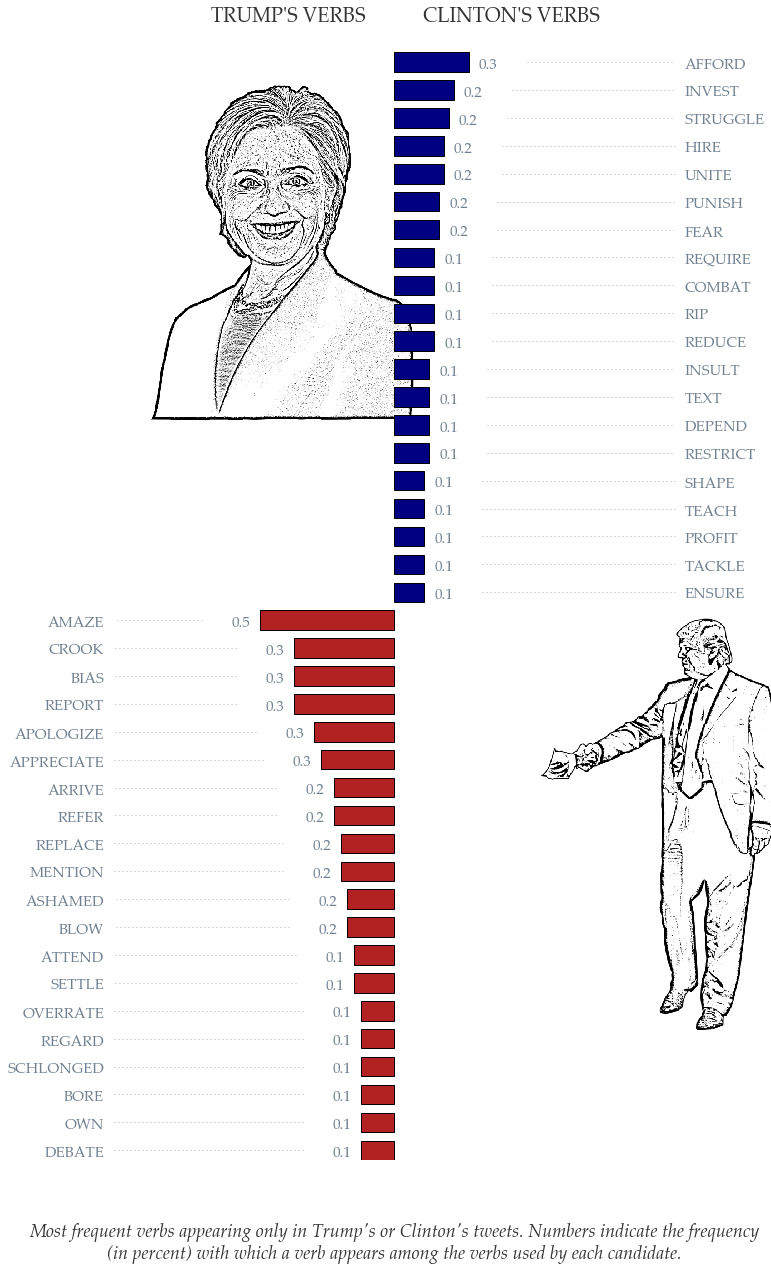

In [18]:
from PIL import Image

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

fig = plt.figure(figsize=(13,20), frameon=False)
plt.axis('off')

bar_pos_trump = np.arange(len(sorted_unique_trump_vb))
bar_pos_clinton = len(sorted_unique_trump_vb) + np.arange(len(sorted_unique_clinton_vb))
bar_width = 0.7

plt.barh(bar_pos_clinton, 
        [x[1] for x in sorted_unique_clinton_vb], 
        color='navy', height=bar_width)
plt.barh(bar_pos_trump,
        [-x[1] for x in sorted_unique_trump_vb],
        color='firebrick', height=bar_width)
tc = 'slategray'
for i, vb in zip(bar_pos_trump, sorted_unique_trump_vb):
    tloc = -1
    talign = 'right'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)
for i, vb in zip(bar_pos_clinton, sorted_unique_clinton_vb):
    tloc = 1
    talign = 'left'
    offset = abs(tloc)/30*np.sign(tloc)
    lstart = np.max(vb[1]) * np.sign(tloc) + 6*offset
    nmax_label = lstart
    nmin_label = np.min(vb[1])*np.sign(offset) 
    lend = tloc - offset
    plt.text(tloc, i, vb[0].upper(), va='bottom', ha=talign, color=tc, **pfont)
    plt.text(np.max(vb[1]) * np.sign(tloc) + offset, i, "%.1f" % np.max(vb[1]), 
             ha=talign, va='bottom', color=tc, **pfont)
    plt.plot([lstart, lend], [i+bar_width/2, i+bar_width/2], 
              linestyle='dotted', c='k', alpha=0.3, linewidth=1)

plt.xlim([-abs(tloc)*1.25,abs(tloc)*1.25])
plt.text(-0.1, np.max(bar_pos_clinton)+1.8, "TRUMP'S VERBS", ha='right', fontsize=20, alpha=0.8, **pfont)
plt.text(0.1, np.max(bar_pos_clinton)+1.8, "CLINTON'S VERBS", ha='left', fontsize=20, alpha=0.8, **pfont)
plt.text(0, -3.5, 
         """Most frequent verbs appearing only in Trump's or Clinton's tweets. Numbers indicate the frequency
(in percent) with which a verb appears among the verbs used by each candidate.""", fontsize=18, alpha=0.8, 
         ha='center', style='italic', **pfont)

hc_sketch = Image.open('../figs/hillary-sketch.png')
hc_sketch = hc_sketch.resize((int(hc_sketch.size[0]//2.2), int(hc_sketch.size[1]//2.2)))
hc_sketch = np.array(hc_sketch).astype(np.float) / 255
fig.figimage(hc_sketch, 130, 850, origin='upper', cmap='gray')

dt_sketch = Image.open('../figs/trump-sketch.png')
dt_sketch = dt_sketch.resize((int(dt_sketch.size[0]//1.8), int(dt_sketch.size[1]//1.8)))
dt_sketch = np.array(dt_sketch).astype(np.float) / 255
fig.figimage(dt_sketch, 540, 240, origin='upper', cmap='gray')

plt.savefig('../figs/unique_vb.pdf')

In [19]:
# make emotion dictionary
emo_file = "../data/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt" 
emo_dict = {}
with open(emo_file, 'r') as f:
    for emo_line in f.readlines()[46:]:
        emo_info = emo_line.split()
        word = emo_info[0]
        emo = emo_info[1]
        emo_score = int(emo_info[2].strip())
        if word not in emo_dict:
            emo_dict[word] = {}
        emo_dict[word][emo] = emo_score

In [20]:
emo_dict_clinton = {'anger': 0,
                    'anticipation': 0,
                    'disgust': 0,
                    'fear': 0,
                    'joy': 0,
                    'negative': 0,
                    'positive': 0,
                    'sadness': 0,
                    'surprise': 0,
                    'trust': 0}
for word in set(words_clinton):
    if word not in emo_dict:
        continue
    for emo in emo_dict[word]:
        emo_dict_clinton[emo] += words_clinton.count(word) * emo_dict[word][emo] / n_words_clinton * 100.
        
emo_dict_trump = {'anger': 0,
                  'anticipation': 0,
                  'disgust': 0,
                  'fear': 0,
                  'joy': 0,
                  'negative': 0,
                  'positive': 0,
                  'sadness': 0,
                  'surprise': 0,
                  'trust': 0}
for word in set(words_trump):
    if word not in emo_dict:
        continue
    for emo in emo_dict[word]:
        emo_dict_trump[emo] += words_trump.count(word) * emo_dict[word][emo] / n_words_trump * 100.

In [21]:
def move_element(l, w, p):
    v = [x for x in l if x[0] == w][0]
    l = [x for x in l if x[0] != w]
    l.insert(p, v)
    return l

sorted_emo_dict_trump = sorted(emo_dict_trump.items(), key=lambda x: x[0], reverse=True)
sorted_emo_dict_clinton = sorted(emo_dict_clinton.items(), key=lambda x: x[0], reverse=True)

sorted_emo_dict_trump = move_element(sorted_emo_dict_trump, "positive", 0)
sorted_emo_dict_trump = move_element(sorted_emo_dict_trump, "negative", 0)

sorted_emo_dict_clinton = move_element(sorted_emo_dict_clinton, "positive", 0)
sorted_emo_dict_clinton = move_element(sorted_emo_dict_clinton, "negative", 0)

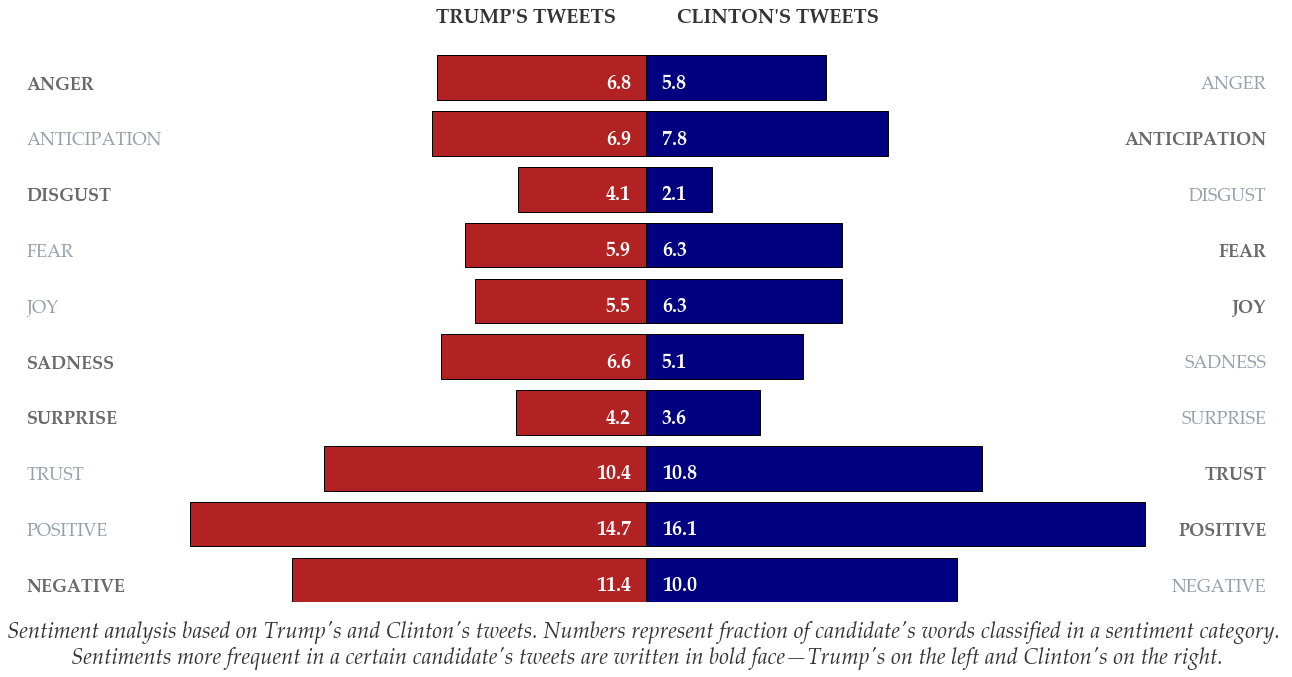

In [22]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}
tc = 'slategray'

fig = plt.figure(figsize=(20, 10))
plt.axis('off')

bar_pos = np.arange(10)
bar_width = 0.7

clinton_keys = [x[0] for x in sorted_emo_dict_clinton]
trump_keys = [x[0] for x in sorted_emo_dict_trump]
clinton_vals = [x[1] for x in sorted_emo_dict_clinton]
trump_vals = [-x[1] for x in sorted_emo_dict_trump]

plt.barh(bar_pos, clinton_vals, color='navy')
plt.barh(bar_pos, trump_vals, color='firebrick')

for pos, emo in zip(bar_pos, clinton_keys):
    if emo_dict_clinton[emo] > emo_dict_trump[emo]:
        tw_right, tw_left = 'black', 'light'
        tc_right, tc_left = 'dimgray', tc
        tal_right, tal_left = 1., 0.75
    elif emo_dict_clinton[emo] < emo_dict_trump[emo]:
        tw_right, tw_left = 'light', 'black'
        tc_right, tc_left = tc, 'dimgray'
        tal_right, tal_left = 0.75, 1.0
    else:
        tw_right, tw_left = 'black', 'black'
        tc_right, tc_left = 'dimgray', 'dimgray'
        tal_right, tal_left = 1.0, 1.0
    plt.text(20, pos+0.1, emo.upper(), va='bottom', ha='right', 
             color=tc_right, fontsize=18, weight=tw_right, alpha=tal_right, **pfont)
    plt.text(-20, pos+0.1, emo.upper(), va='bottom', ha='left', 
             color=tc_left, fontsize=18, weight=tw_left, alpha=tal_left, **pfont)
    plt.text(0.5, pos+0.1, "%.1f" % emo_dict_clinton[emo], weight='black', va='bottom', 
             ha='left', color='white', fontsize=20, **pfont)
    plt.text(-0.5, pos+0.1, "%.1f" % emo_dict_trump[emo], weight='black', va='bottom', 
             ha='right', color='white', fontsize=20, **pfont)

plt.text(1, 10.4, "CLINTON'S TWEETS", fontsize=20, ha='left', alpha=0.8, weight='heavy', **pfont)
plt.text(-1, 10.4, "TRUMP'S TWEETS", fontsize=20, ha='right', alpha=0.8, weight='heavy', **pfont)
plt.text(0, -1.1, """Sentiment analysis based on Trump's and Clinton's tweets. Numbers represent fraction of candidate's words classified in a sentiment category. 
Sentiments more frequent in a certain candidate's tweets are written in bold face—Trump's on the left and Clinton's on the right.""", 
         fontsize=22, alpha=0.8, 
         ha='center', style='italic', **pfont)

plt.xlim([-18,18])

plt.savefig("../figs/positive_vs_negative.pdf")